<a href="https://colab.research.google.com/github/hooberman/Titanic/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# load libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# download train and test datasets
!wget -q https://www.dropbox.com/scl/fi/8pxqu7flfpo6vbfy9kfik/train.csv?rlkey=2m6wb3giuk8fnu446dipd4ci3&dl=0
!wget -q https://www.dropbox.com/scl/fi/jbn4a5kod490w4a9x249y/test.csv?rlkey=5ai92yg6iehi96kt83fz662lx&dl=0
!mv train.csv?rlkey=2m6wb3giuk8fnu446dipd4ci3 sample_data/train.csv
!mv test.csv?rlkey=5ai92yg6iehi96kt83fz662lx  sample_data/test.csv

Extract, transform, and load

In [31]:
# read in data
df_train = pd.read_csv("./sample_data/train.csv")
df_test  = pd.read_csv("./sample_data/test.csv")

# remove Name (might be useful, to be revisited)
del (df_train['Name'])
del (df_test['Name'])

# remove Cabin (too many missing values)
del (df_train['Cabin'])
del (df_test['Cabin'])

# remove useless PassengerId
del (df_train['PassengerId'])
del (df_test['PassengerId'])

# remove Ticket (this might be useful but has a weird format, to be revisited)
del (df_train['Ticket'])
del (df_test['Ticket'])

# one-hot encode Sex
df_test  = pd.get_dummies(df_test,  columns=['Sex'],drop_first=True)
df_train = pd.get_dummies(df_train, columns=['Sex'],drop_first=True)

# one-hot encode Embarked
df_test  = pd.get_dummies(df_test,  columns=['Embarked'],drop_first=True)
df_train = pd.get_dummies(df_train, columns=['Embarked'],drop_first=True)

# replace missing Age values with mean age
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].mean())
df_test['Age']  = df_test['Age'].fillna(df_train['Age'].mean())

# replace missing Fare value
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].mean())

# standardize Age and Fare
scaler = StandardScaler()
df_train['Age']  = scaler.fit_transform(df_train[['Age']])
df_test['Age']   = scaler.transform(df_test[['Age']])
df_train['Fare'] = scaler.fit_transform(df_train[['Fare']])
df_test['Fare']  = scaler.transform(df_test[['Fare']])

# split training dataset into features and labels
features = df_train.drop('Survived', axis=1)
labels = df_train['Survived']

# Split data into training and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert Pandas DataFrames to TensorFlow datasets
#train_dataset = tf.data.Dataset.from_tensor_slices((train_features.values, train_labels.values))
#val_dataset   = tf.data.Dataset.from_tensor_slices((val_features.values, val_labels.values))

#labels.head()
#df_train.head(50)
#df_train.info()
#df_train.describe()
#df_test.info()
print('\nFirst five entries of training dataset')
df_train.head()
#print('\nTraining dataset description')
#df_train.describe()


First five entries of training dataset


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,-0.592481,1,0,-0.502445,1,0,1
1,1,1,0.638789,1,0,0.786845,0,0,0
2,1,3,-0.284663,0,0,-0.488854,0,0,1
3,1,1,0.407926,1,0,0.420730,0,0,1
4,0,3,0.407926,0,0,-0.486337,1,0,1


Exploratory data analysis

First five entries of train dataset

Train dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_male    891 non-null    uint8  
 7   Embarked_Q  891 non-null    uint8  
 8   Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 44.5 KB

Train dataset description

Distributions

Correlation with Survived
Survived      1.000000
Fare          0.257307
Parch         0.081629
Embarked_Q    0.003650
SibSp        -0.035322
Age          -0.069809
Embarked_S   -0.155660
Pclass       -0.338481
Sex_male     -0.543351
Name: Survived, dtype: float64


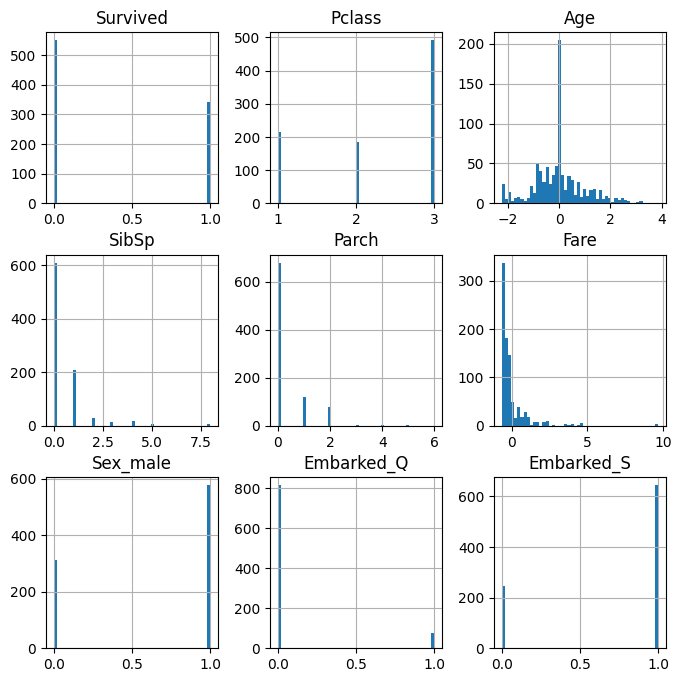

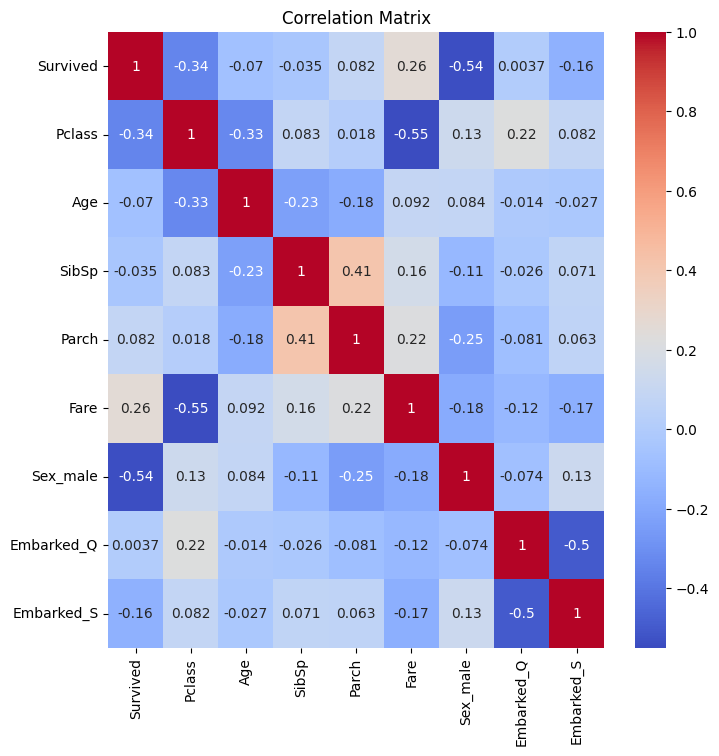

In [35]:
print('First five entries of train dataset')
df_train.head()
print('\nTrain dataset info')
df_train.info()
print('\nTrain dataset description')
df_train.describe()

print('\nDistributions')
df_train.hist(bins=50,figsize=(8,8))
corr_matrix = df_train.corr()
print('\nCorrelation with Survived')
print(corr_matrix['Survived'].sort_values(ascending=False))

# correlation plot
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Define, compile, and train the TensorFlow model

In [13]:
# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(train_features.shape[1],)),
    #tf.keras.layers.Dense(5, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_features,train_labels,epochs=100)

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(train_features,train_labels)
print(f'Training Loss: {train_loss}')
print(f'Training Accuracy: {train_accuracy}')

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_features,val_labels)
print(f'Val Loss: {val_loss}')
print(f'Val Accuracy: {val_accuracy}')

# get predictions on test set
predictions = model.predict(df_test)
survived = (predictions > 0.5).astype(int).squeeze()

#output file
df_test2 = pd.read_csv("./sample_data/test.csv")
output = pd.DataFrame({'PassengerId':df_test2['PassengerId'], 'Survived': survived})
output.to_csv('submission.csv', index=False)

print(output)

Epoch 1/100
23/23 [==============================] - 2s 6ms/step - loss: 3.3702 - accuracy: 0.5618
Epoch 2/100
23/23 [==============================] - 0s 5ms/step - loss: 3.2343 - accuracy: 0.6236
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 3.1231 - accuracy: 0.6236
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 3.0209 - accuracy: 0.6292
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 2.9239 - accuracy: 0.6545
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 2.8320 - accuracy: 0.6573
Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 2.7419 - accuracy: 0.6713
Epoch 8/100
23/23 [==============================] - 0s 5ms/step - loss: 2.6565 - accuracy: 0.6910
Epoch 9/100
23/23 [==============================] - 0s 4ms/step - loss: 2.5740 - accuracy: 0.6952
Epoch 10/100
23/23 [==============================] - 0s 8ms/step - loss: 2.4951 - accuracy: 0.7191
Epoch 11/